In [ ]:
from google.colab import files

# This will prompt you to select the kaggle.json file
files.upload()

In [19]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !pip install kaggle
!kaggle competitions download -c bird-classification-competition

In [ ]:
!unzip -q bird-classification-competition.zip

In [21]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/bird-classification-competition.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/bird-classification-competition')




In [ ]:
# !pip install --upgrade pip
!pip install boto3
!pip install sagemaker
!pip install torch torchvision

In [ ]:
# Get base directory and create folder for saving model checkpoints
# This is colab code, so change it to VS Code accordingly
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm
from google.colab import drive
import pandas as pd
from PIL import Image
import json

# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print GPU info
!nvidia-smi

# Mount Google Drive to a new directory
drive.mount('/content/gdrive')

# Define directories
base_dir = '/content/bird-classification-competition/Upload/Upload'  # Assuming this is where your unzipped files are
checkpoint_dir = '/content/gdrive/MyDrive/bird_classification_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Print current working directory and its contents
print("Current working directory:", os.getcwd())
print("\nContents of the current directory:")
for item in os.listdir():
    print(item)

# Print contents of the base directory
print(f"\nContents of {base_dir}:")
for item in os.listdir(base_dir):
    print(item)



In [ ]:
#TRAIN AND EVALUATE MODEL
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image
import json
from sklearn.metrics import f1_score
import numpy as np
from torch.amp import autocast, GradScaler


# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define directories
base_dir = '/content/bird-classification-competition/Upload/Upload'
checkpoint_dir = '/content/gdrive/MyDrive/bird_classification_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def correct_csv_paths(csv_file, root_dir):
    df = pd.read_csv(csv_file)
    corrected_paths = []
    for path in df['filepaths']:
        corrected_path = path.replace('AKULET', 'AUKLET')
        if not os.path.exists(os.path.join(root_dir, corrected_path)):
            print(f"Warning: File not found: {corrected_path}")
        corrected_paths.append(corrected_path)
    df['filepaths'] = corrected_paths
    corrected_csv_file = csv_file.replace('.csv', '_corrected.csv')
    df.to_csv(corrected_csv_file, index=False)
    print(f"Corrected CSV saved as: {corrected_csv_file}")
    return corrected_csv_file

# Custom Dataset
class BirdDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, is_test=False):
        self.csv_file = correct_csv_paths(csv_file, root_dir)
        self.bird_data = pd.read_csv(self.csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        if not is_test:
            self.class_to_idx = {class_id: idx for idx, class_id in enumerate(self.bird_data['class id'].unique())}
            self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

    def __len__(self):
        return len(self.bird_data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.bird_data.iloc[idx]['filepaths'])
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            # Use a placeholder image or skip this sample
            image = Image.new('RGB', (224, 224), color='gray')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, self.bird_data.iloc[idx]['ID']
        else:
            class_id = self.bird_data.iloc[idx]['class id']
            label = self.class_to_idx[class_id]
            return image, label, self.bird_data.iloc[idx]['ID']


# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = BirdDataset(csv_file=os.path.join(base_dir, 'train.csv'), root_dir=base_dir, transform=transform)
val_dataset = BirdDataset(csv_file=os.path.join(base_dir, 'val.csv'), root_dir=base_dir, transform=transform)
test_dataset = BirdDataset(csv_file=os.path.join(base_dir, 'test.csv'), root_dir=base_dir, transform=transform, is_test=True)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.class_to_idx)
print(f"Number of classes: {num_classes}")


def create_model(num_classes):
    model = torchvision.models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

model = create_model(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()


# In your training function, update the autocast usage
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss = 0.0
    for inputs, labels, _ in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        # Use the updated autocast syntax
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return f1_score(all_labels, all_preds, average='weighted')

# Training loop
num_epochs = 10
best_val_f1 = 0
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_f1 = evaluate(model, val_loader)
    print(f"Training Loss: {train_loss:.4f}, Validation F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
        }, best_model_path)
        print(f"New best model saved with F1: {val_f1:.4f}")

print("Training completed.")




Using device: cuda:0
Corrected CSV saved as: /content/bird-classification-competition/Upload/Upload/train_corrected.csv
Corrected CSV saved as: /content/bird-classification-competition/Upload/Upload/val_corrected.csv
Corrected CSV saved as: /content/bird-classification-competition/Upload/Upload/test_corrected.csv
Number of classes: 525


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 1.8816, Validation F1: 0.0006
New best model saved with F1: 0.0006
Epoch 2/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 0.9213, Validation F1: 0.0007
New best model saved with F1: 0.0007
Epoch 3/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e5ca7106170>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e5ca7106170>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e5ca7106170>      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e5ca7106170>
self._shutdown_workers()Traceback (most recent call last):
    

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

  File "/usr/local/l

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 0.8009, Validation F1: 0.0003
Epoch 4/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 0.7360, Validation F1: 0.0000
Epoch 5/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 0.6767, Validation F1: 0.0005
Epoch 6/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 0.6395, Validation F1: 0.0000
Epoch 7/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 0.6110, Validation F1: 0.0003
Epoch 8/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 0.5940, Validation F1: 0.0007
Epoch 9/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 0.5684, Validation F1: 0.0000
Epoch 10/10


Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/3.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/1.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/5.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/4.jpg
File not found: /content/bird-classification-competition/Upload/Upload/valid/PARAKETT  AUKLET/2.jpg
Training Loss: 0.5548, Validation F1: 0.0002
Training completed.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded best model from epoch 1 with validation F1: 0.0007


<ipython-input-19-93e10a70e740>:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


Generating predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Submission file created: submission.csv
Final model and class mapping saved.


In [ ]:
# Load the best model for prediction
best_model = create_model(num_classes).to(device)
checkpoint = torch.load(best_model_path)
best_model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with validation F1: {checkpoint['val_f1']:.4f}")



In [ ]:


##Extract for submission for kaggle
## Do not move this to AWS, this is only for local prediction for kaggle
## Instead of best_model variable here, use the actual model .pth file
import pandas as pd
import torch
from tqdm.notebook import tqdm

def generate_submission(model, loader, idx_to_class):
    model.eval()
    submissions = []
    with torch.no_grad():
        for inputs, ids in tqdm(loader, desc="Generating predictions"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            for id, pred in zip(ids, preds):
                # Convert ID to integer and then to string
                id_value = str(int(float(id.item() if isinstance(id, torch.Tensor) else id)))
                # Convert class_id to integer and then to string
                class_id = str(int(float(idx_to_class[pred.item()])))
                submissions.append([id_value, class_id])

    submission_df = pd.DataFrame(submissions, columns=['ID', 'class id'])
    return submission_df

# Generate the submission DataFrame
submission_df = generate_submission(best_model, test_loader, train_dataset.idx_to_class)

# Function to remove decimal places from a value
def remove_decimal(value):
    return str(int(float(value)))

# Apply the function to both columns
submission_df['ID'] = submission_df['ID'].apply(remove_decimal)
submission_df['class id'] = submission_df['class id'].apply(remove_decimal)

# Verify the contents of the DataFrame
print("Preview of submission DataFrame:")
print(submission_df.head())
print("\nData types:")
print(submission_df.dtypes)

# Save the submission file
submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)
print(f"\nSubmission file created: {submission_file_path}")

# Read back the CSV to double-check
check_df = pd.read_csv(submission_file_path)
print("\nChecking saved CSV:")
print(check_df.head())
print("\nData types of saved CSV:")
print(check_df.dtypes)

# Additional check to ensure no decimal points
print("\nUnique ID values (first 10):")
print(check_df['ID'].unique()[:10])
print("\nUnique class id values (first 10):")
print(check_df['class id'].unique()[:10])

# Final verification
with open(submission_file_path, 'r') as f:
    print("\nFirst few lines of the CSV file:")
    for _ in range(6):  # Print first 6 lines
        print(f.readline().strip())

Generating predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Preview of submission DataFrame:
      ID class id
0  84889       50
1  86543      381
2  85894      251
3  85071       87
4  86904      453

Data types:
ID          object
class id    object
dtype: object

Submission file created: submission.csv

Checking saved CSV:
      ID  class id
0  84889        50
1  86543       381
2  85894       251
3  85071        87
4  86904       453

Data types of saved CSV:
ID          int64
class id    int64
dtype: object

Unique ID values (first 10):
[84889 86543 85894 85071 86904 85383 87034 84667 84708 85285]

Unique class id values (first 10):
[ 50 381 251  87 453 149 479   6  14 130]

First few lines of the CSV file:
ID,class id
84889,50
86543,381
85894,251
85071,87
86904,453


In [ ]:
###SAVE THE FINAL BEST MODEL in stat_dict form
torch.save(model.state_dict(), '/content/gdrive/MyDrive/bird_classification_final_model.pth')
print("Final model saved to Google Drive")

Final model saved to Google Drive


In [ ]:

#Comprehensive Model Preparation with Common and Scientific Names that will be deployed to AWS S3
import torch
import torchvision.models as models
import pandas as pd
from torch.utils.data import Dataset, ConcatDataset
from google.colab import drive
import os
from PIL import Image
import torchvision.transforms as transforms

# Mount Google Drive
drive.mount('/content/drive')

class BirdDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {row['labels']: idx for idx, row in self.data.drop_duplicates('labels').iterrows()}
        self.class_to_scientific = dict(zip(self.data['labels'], self.data['scientific name']))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx]['filepaths'])
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.data.iloc[idx]['labels']]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
base_dir = '/content/bird-classification-competition/Upload/Upload'
train_dataset = BirdDataset(csv_file='/content/train.csv', root_dir=base_dir, transform=transform)
val_dataset = BirdDataset(csv_file='/content/val.csv', root_dir=base_dir, transform=transform)

# Combine train and val datasets for comprehensive class mapping
all_classes = set()
all_scientific_names = {}
for dataset in [train_dataset, val_dataset]:
    all_classes.update(dataset.class_to_idx.keys())
    all_scientific_names.update(dataset.class_to_scientific)

class_to_idx = {cls: idx for idx, cls in enumerate(sorted(all_classes))}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
idx_to_scientific = {idx: all_scientific_names[cls] for idx, cls in idx_to_class.items()}


# Load the existing model state dict
existing_state_dict = torch.load('/content/drive/MyDrive/bird_classification_final_model.pth', map_location=torch.device('cpu'))

# Recreate the model architecture
num_classes = len(class_to_idx)
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load the state dict into the model
model.load_state_dict(existing_state_dict)

# Save the model with the comprehensive class mapping
torch.save({
    'model_state_dict': model.state_dict(),
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'idx_to_scientific': idx_to_scientific
}, '/content/drive/MyDrive/bird_classification_final_model_with_names.pth')

print(f"Model saved with comprehensive class mapping. Total classes: {num_classes}")

# Verify the saved data
saved_data = torch.load('/content/drive/MyDrive/bird_classification_final_model_with_names.pth')
print("Keys in saved data:", saved_data.keys())
print("Number of classes:", len(saved_data['idx_to_class']))
print("Sample of idx_to_class:", dict(list(saved_data['idx_to_class'].items())[:5]))
print("Sample of idx_to_scientific:", dict(list(saved_data['idx_to_scientific'].items())[:5]))

In [ ]:
##Local Predictions for the test.csv file
## Do not move this to AWS

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os

def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_info = torch.load(model_path, map_location=device)

    num_classes = len(model_info['class_to_idx'])
    model = models.resnet50(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

    model.load_state_dict(model_info['model_state_dict'])
    model.eval()
    return model, model_info['class_to_idx']

def process_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def predict(model, image_tensor, idx_to_label):
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        output = model(image_tensor)

    _, predicted_idx = torch.max(output, 1)
    return idx_to_label[predicted_idx.item()]

# Load CSVs
train_df = pd.read_csv('/content/train.csv')
val_df = pd.read_csv('/content/val.csv')
test_df = pd.read_csv('/content/test.csv')

# Combine train and val dataframes
combined_df = pd.concat([train_df, val_df])

# Create mappings
label_to_class_id = dict(zip(combined_df['labels'], combined_df['class id']))
label_to_scientific = dict(zip(combined_df['labels'], combined_df['scientific name']))

# Load the model
model_path = '/content/drive/MyDrive/bird_classification_final_model_with_names.pth'
model, class_to_idx = load_model(model_path)

# Create a reverse mapping from class index to label
idx_to_label = {v: k for k, v in class_to_idx.items()}

# Function to predict on a single image
def predict_image(image_path):
    image_tensor = process_image(image_path)
    predicted_label = predict(model, image_tensor, idx_to_label)

    if predicted_label not in label_to_class_id:
        print(f"Warning: Predicted label '{predicted_label}' not found in label_to_class_id mapping.")
        return None, None, predicted_label

    class_id = label_to_class_id[predicted_label]
    scientific_name = label_to_scientific[predicted_label]

    return class_id, scientific_name, predicted_label

# Predict for all test images
results = []
base_dir = '/content/bird-classification-competition/Upload/Upload'

for _, row in test_df.iterrows():
    image_id = row['ID']
    image_path = os.path.join(base_dir, row['filepaths'])
    class_id, scientific_name, predicted_label = predict_image(image_path)
    results.append({
        'ID': image_id,
        'class id': class_id if class_id is not None else 'Unknown',
        'scientific name': scientific_name if scientific_name is not None else 'Unknown',
        'predicted_label': predicted_label
    })

# Create a dataframe with results
results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

# Display first few predictions
print(results_df.head())

# Print some debug information
print("\nDebug Information:")
print(f"Number of classes in class_to_idx: {len(class_to_idx)}")
print(f"Number of classes in idx_to_label: {len(idx_to_label)}")
print(f"Number of classes in label_to_class_id: {len(label_to_class_id)}")
print(f"Number of classes in label_to_scientific: {len(label_to_scientific)}")
print("\nSample of idx_to_label:")
print(dict(list(idx_to_label.items())[:5]))
print("\nSample of label_to_class_id:")
print(dict(list(label_to_class_id.items())[:5]))

# Check for IVORY GULL specifically
if 'IVORY GULL' in label_to_class_id:
    print("\nIVORY GULL class ID:", label_to_class_id['IVORY GULL'])
else:
    print("\nIVORY GULL not found in label_to_class_id mapping")

In [ ]:
# !pip install --upgrade pip
!pip install boto3
!pip install sagemaker
!pip install torch torchvision

In [12]:
#Getting the model architecture
import torch
from google.colab import drive, userdata

# Mount Google Drive
drive.mount('/content/gdrive')
# Load your model
model = torch.load('/content/gdrive/MyDrive/bird_classification_final_model_with_comprehensive_mapping.pth')

# Print model architecture
print(model)

# If it's just the state dict, you might need to initialize your model first
# model = YourModelClass(...)
# model.load_state_dict(torch.load('/content/drive/MyDrive/bird_classification_final_model.pth'))
# print(model)

Mounted at /content/gdrive


<ipython-input-12-26cbec2b2e46>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/gdrive/MyDrive/bird_classification_final_model_with_comprehensi

{'model_state_dict': OrderedDict([('conv1.weight', tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
       

In [ ]:
#Just to Check files in current directory
import os
print("Current working directory:", os.getcwd())

# List files in the current directory
print("\nFiles in the current directory:")
print(os.listdir())

Current working directory: /content

Files in the current directory:
['.config', 'kaggle.json', 'submission.csv', 'gdrive', 'bird-classification-competition.zip', 'drive', 'bird-classification-competition', 'sample_data']


In [34]:
# Content for inference.py
inference_content = """
import json
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import io
import os

def model_fn(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 525)  # Adjust if your number of classes is different
    model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pth'), map_location=device))
    model.eval()

    # Load class mappings
    with open(os.path.join(model_dir, 'class_mapping.json'), 'r') as f:
        class_mapping = json.load(f)

    return {'model': model, 'class_mapping': class_mapping}

def input_fn(request_body, request_content_type):
    if request_content_type == 'application/x-image':
        image = Image.open(io.BytesIO(request_body))
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        return transform(image).unsqueeze(0)
    raise ValueError(f"Unsupported content type: {request_content_type}")

def predict_fn(input_data, model_dict):
    model = model_dict['model']
    class_mapping = model_dict['class_mapping']
    device = next(model.parameters()).device
    input_data = input_data.to(device)
    with torch.no_grad():
        output = model(input_data)

    _, predicted_idx = torch.max(output, 1)
    predicted_label = class_mapping['idx_to_label'][str(predicted_idx.item())]
    class_id = class_mapping['label_to_class_id'][predicted_label]
    scientific_name = class_mapping['label_to_scientific'][predicted_label]

    return {'class_id': class_id, 'scientific_name': scientific_name, 'predicted_label': predicted_label}

def output_fn(prediction, accept):
    return json.dumps(prediction)
"""

# Write the inference.py file
with open('inference.py', 'w') as f:
    f.write(inference_content)

print("Created inference.py in the current directory.")

# Verify the file was created
print("\nUpdated files in the current directory:")
print(os.listdir())

Created inference.py in the current directory.

Updated files in the current directory:
['.config', 'model.pth', 'kaggle.json', 'bird-classification-competition.zip', '7.jpg', 'inference.py', 'train.csv', 'model.tar.gz', '8.jpg', 'bird-classification-competition', '3.jpg', 'gdrive', 'test.csv', 'class_mapping.json', '1.jpg', '2.jpg', 'val.csv', 'predictions.csv', 'drive', '9.jpg', 'sample_data']


In [ ]:
import boto3
import sagemaker
from sagemaker.pytorch import PyTorchModel
import torch
import json
import os
from google.colab import drive, userdata
import pandas as pd

# Set up AWS credentials
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = userdata.get('AWS_DEFAULT_REGION')

# Set up AWS session
session = boto3.Session()
sagemaker_session = sagemaker.Session()

# Mount Google Drive
drive.mount('/content/gdrive')

# Define variables
bucket = 'deepan-sagemaker-models'
prefix = 'bird-classification-model'
role = 'arn:aws:iam::340752818264:role/SageMakerDeepan'
model_path = '/content/gdrive/MyDrive/bird_classification_final_model_with_names.pth'

# Load the model and mappings
print("Loading model...")
model_info = torch.load(model_path, map_location=torch.device('cpu'))

# Print model_info keys for debugging
print("Keys in model_info:", model_info.keys())

# Save the model state dict
torch.save(model_info['model_state_dict'], 'model.pth')

# Prepare class mappings
print("Preparing class mappings...")
idx_to_label = model_info.get('idx_to_label', {})
label_to_class_id = model_info.get('label_to_class_id', {})
label_to_scientific = model_info.get('label_to_scientific', {})

# If mappings are missing, try to recreate them from CSV files
if not idx_to_label or not label_to_class_id or not label_to_scientific:
    print("Recreating mappings from CSV files...")
    train_df = pd.read_csv('/content/train.csv')
    val_df = pd.read_csv('/content/val.csv')
    combined_df = pd.concat([train_df, val_df])

    label_to_class_id = dict(zip(combined_df['labels'], combined_df['class id']))
    label_to_scientific = dict(zip(combined_df['labels'], combined_df['scientific name']))
    idx_to_label = {i: label for i, label in enumerate(combined_df['labels'].unique())}

# Save class mappings
with open('class_mapping.json', 'w') as f:
    json.dump({
        'idx_to_label': idx_to_label,
        'label_to_class_id': label_to_class_id,
        'label_to_scientific': label_to_scientific
    }, f)

# Create a tar.gz file
print("Creating tar.gz file...")
with tarfile.open('model.tar.gz', 'w:gz') as tar:
    tar.add('model.pth')
    tar.add('class_mapping.json')

# Upload to S3
print("Uploading to S3...")
sagemaker_session.upload_data('model.tar.gz', bucket=bucket, key_prefix=prefix)
s3_model_path = f's3://{bucket}/{prefix}/model.tar.gz'

# Create SageMaker model
print("Creating SageMaker model...")
pytorch_model = PyTorchModel(
    model_data=s3_model_path,
    role=role,
    framework_version="1.8",
    py_version="py3",
    entry_point="inference.py",
)

# Deploy the model
print("Deploying the model...")
try:
    predictor = pytorch_model.deploy(
        instance_type="ml.t2.medium",
        initial_instance_count=1,
        endpoint_name="bird-classification-endpoint-2"
    )
    print(f"Model deployed successfully. Endpoint name: {predictor.endpoint_name}")
except Exception as e:
    print(f"Error during deployment: {str(e)}")

print("Deployment process completed.")

In [2]:
## Check if service is up and running
import boto3
import os
from google.colab import userdata

# Set up AWS credentials
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = userdata.get('AWS_DEFAULT_REGION')

# Specify the region
region_name = os.environ['AWS_DEFAULT_REGION']
endpoint_name = 'bird-classification-endpoint-2'

# Create a SageMaker client (not SageMaker runtime)
sagemaker_client = boto3.client('sagemaker', region_name=region_name)

try:
    response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f"Endpoint Status: {response['EndpointStatus']}")
    print(f"Failure Reason: {response.get('FailureReason', 'No failure')}")
except sagemaker_client.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'ResourceNotFound':
        print(f"Endpoint '{endpoint_name}' not found. Please check if the endpoint name is correct.")
    else:
        print(f"An error occurred: {e}")

Endpoint Status: InService
Failure Reason: No failure


Prediction Results:
Predicted Label: WILLOW PTARMIGAN
Class ID: 505.0
Scientific Name: LAGOPUS LAGOPUS


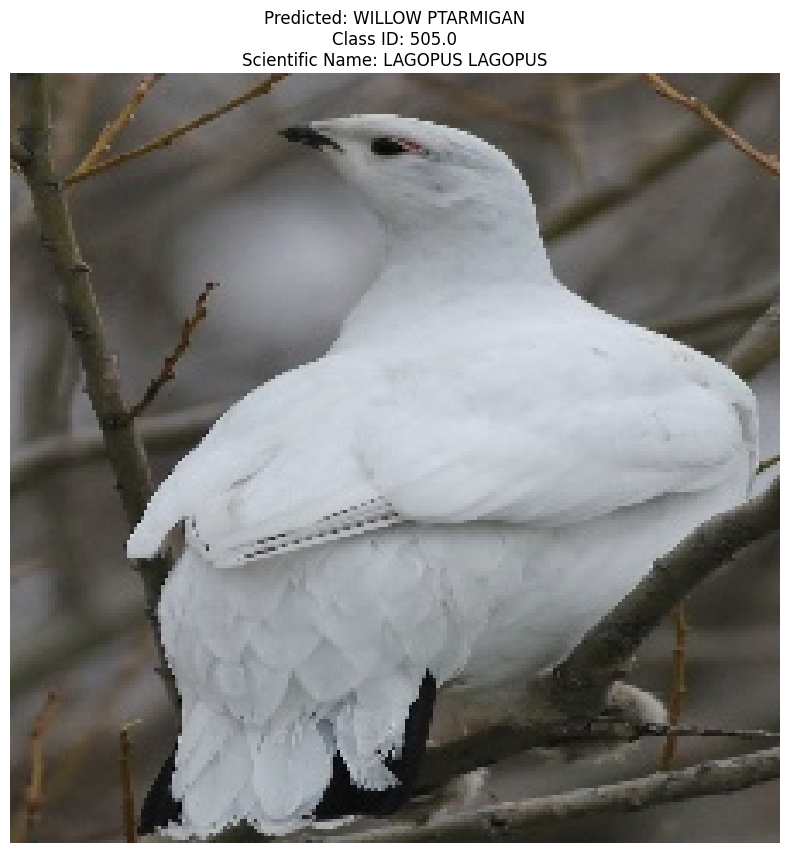

In [6]:
# Code for prediction using local image.
# Prediction against the endpoint bird-classification-endpoint-2
import boto3
import json
from PIL import Image
import matplotlib.pyplot as plt
import io

def predict_image(image_path, endpoint_name):
    # Read the image file
    with open(image_path, 'rb') as f:
        image_data = f.read()

    # Create a SageMaker runtime client
    runtime = boto3.client('sagemaker-runtime')

    # Send the image to the endpoint
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/x-image',
        Body=image_data
    )

    # Parse the response
    result = json.loads(response['Body'].read().decode())

    return result

def display_prediction(image_path, prediction):
    # Open and display the image
    img = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')

    # Add prediction information as text
    plt.title(f"Predicted: {prediction['predicted_label']}\n"
              f"Class ID: {prediction['class_id']}\n"
              f"Scientific Name: {prediction['scientific_name']}")

    plt.show()

# Example usage
endpoint_name = 'bird-classification-endpoint-2'  # Replace with your actual endpoint name
image_path = '/content/2.jpg'  # Replace with the path to your test image

# Make prediction
prediction = predict_image(image_path, endpoint_name)

# Print the prediction
print("Prediction Results:")
print(f"Predicted Label: {prediction['predicted_label']}")
print(f"Class ID: {prediction['class_id']}")
print(f"Scientific Name: {prediction['scientific_name']}")

# Display the image with prediction
display_prediction(image_path, prediction)

In [ ]:
#Flask App to get predictions

from flask import Flask, request, render_template, url_for
import boto3
import json
from PIL import Image
import io
import base64

app = Flask(__name__)

# Configure AWS credentials and region
import os
os.environ['AWS_ACCESS_KEY_ID'] = 'your_access_key_id'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'your_secret_access_key'
os.environ['AWS_DEFAULT_REGION'] = 'your_aws_region'

# SageMaker endpoint name
ENDPOINT_NAME = 'bird-classification-endpoint'

def predict_image(image_bytes):
    runtime = boto3.client('sagemaker-runtime')

    response = runtime.invoke_endpoint(
        EndpointName=ENDPOINT_NAME,
        ContentType='application/x-image',
        Body=image_bytes
    )

    result = json.loads(response['Body'].read().decode())
    return result

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        if 'file' not in request.files:
            return render_template('index.html', error='No file part')

        file = request.files['file']

        if file.filename == '':
            return render_template('index.html', error='No selected file')

        if file:
            # Read the image file
            image_bytes = file.read()

            try:
                # Get prediction
                prediction = predict_image(image_bytes)

                # Convert image to base64 for displaying
                img = Image.open(io.BytesIO(image_bytes))
                img_base64 = base64.b64encode(image_bytes).decode('utf-8')

                return render_template('result.html',
                                       image=img_base64,
                                       class_id=prediction['class_id'],
                                       scientific_name=prediction['scientific_name'],
                                       predicted_label=prediction['predicted_label'])
            except Exception as e:
                return render_template('index.html', error=f'Error during prediction: {str(e)}')

    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=True)